In [2]:
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v86)
library(ggplot2)
library(patchwork)
library(hdf5r) 
library(future)
library(RColorBrewer)
library(dplyr)
library(Matrix)
library(BSgenome.Hsapiens.UCSC.hg38)
library(glue)
library(harmony)
library(matrixStats)
library(scales)
library(biomaRt)
library(curl)
library(goseq)
library(httr)
library(Scillus)
library(TFBSTools)
library(JASPAR2020)
library(ggridges)
library(ggrepel)
library(ggsignif)
library(qusage)
library(tidyverse)
httr::set_config(config(ssl_verifypeer = 0L))
set.seed(1234)
setwd('data/inhouse_wu_long_yu')

# Figure S2A: Proportion of cells in each RCC tumor cluster

Wrangle data
- Remove non-QC passing cells
- Rename clusters to match figure 2

In [ ]:
# Load in metadata indicating which cells did not pass QC
obj = readRDS('allcells/seurat_obj/integrated_allcohorts_seuratobj_geneactivity_lsi_metadata_qc_motifs_annotated_detailed.rds')
obj$ATAC = NULL
excluded = row.names(obj@meta.data %>% filter(broad_celltype_excluded == 'Excluded'))
rm(obj)

# Remove excluded cells from tumor object
tumor = readRDS('allcells/tumor/seurat_obj/integrated_tumor_broadanno_Oct2023.rds')
tumor_passqc = setdiff(row.names(tumor@meta.data), excluded)
tumor_filtered = subset(tumor, cells = tumor_passqc)

# Rename cluster names to match names used in figure 2
newIDs = list(
    "890 EGFR-high" = 'NCAM1-high',
    "909 PDGFRA-high" = 'PDGFRA-high',
    "ccRCC balanced" = 'ccRCC balanced',
    "Papillary RADIL-high" = 'RADIL-high',
    "SRR19987214 CADM1-high" = 'CADM1-high',
    "XpTranslocation TRIM63-high" = 'TRIM63-high')
metadata = tumor_filtered@meta.data
metadata$new_barcodes = row.names(metadata)
df = data.frame(tumor_annotation = names(newIDs), annotation = unlist(unname(newIDs)))
meta_df = dplyr::inner_join(metadata,df, by = 'tumor_annotation')
row.names(meta_df) = meta_df$new_barcodes
tumor_filtered = AddMetaData(tumor_filtered, metadata = meta_df %>% 
                                                                 dplyr::select('annotation'))

# Add metadata column that concatenates cluster name and seurat cluster number, for plotting
tumor_filtered$plot = paste0(tumor_filtered$annotation, ' (', tumor_filtered$seurat_clusters, ')')
order = (tumor_filtered@meta.data %>% dplyr::select(seurat_clusters, plot) %>% distinct() %>% arrange(as.numeric(seurat_clusters)))$plot
tumor_filtered$plot = factor(tumor_filtered$plot, levels = order)

## By sample

In [4]:
# Set colors per sample
sample_cols <- colorRampPalette(brewer.pal(16, "Set2"))(68)

Warning message in brewer.pal(16, "Set2"):
"n too large, allowed maximum for palette Set2 is 8
Returning the palette you asked for with that many colors
"


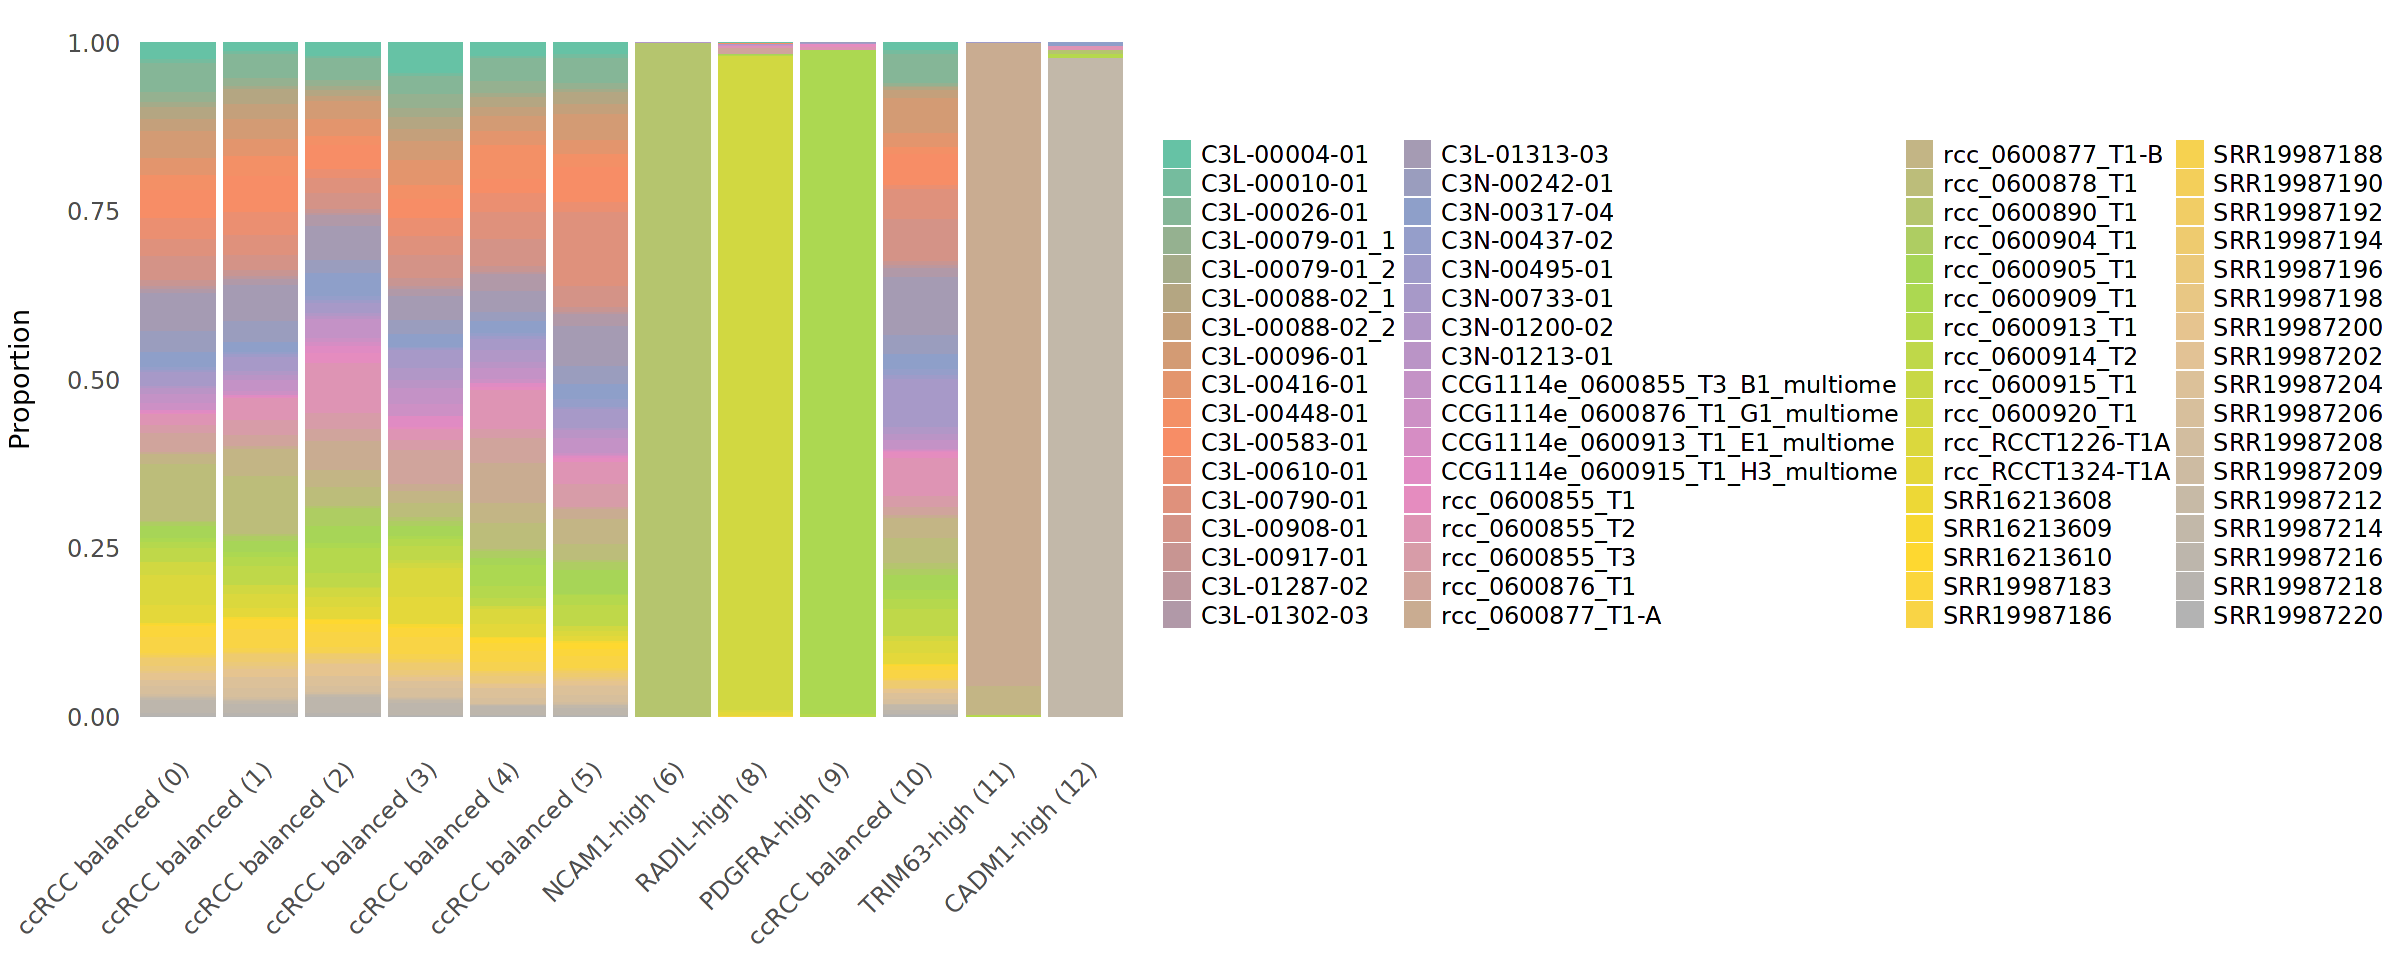

In [8]:
# Calculate proportion of cells in each cluster from each sample
df_summary <- tumor_filtered@meta.data %>%
  dplyr::count(plot, sample) %>%
  group_by(plot) %>%
  mutate(proportion = n / sum(n)) %>%
  ungroup()

options(repr.plot.width=20, repr.plot.height=8)
# Create proportional stacked bar plot
ggplot(df_summary, aes(x = plot, y = proportion, fill = sample)) +
    geom_bar(stat = "identity", position = "fill") + 
    labs(y = "Proportion", x = "Cell Type", fill = "Cohort") + 
    theme_classic() + 
    theme(plot.title = element_text(hjust = 0.5, face = 'plain'),
          legend.title = element_blank(),
          legend.text=element_text(size=14),
          axis.title.x=element_blank(),
          axis.title.y = element_text(size = 16, margin = margin(t = 0, r = 20, b = 0, l = 0)),
          axis.ticks=element_blank(),
          axis.line=element_blank(),
          axis.text.x = element_text(angle = 45, hjust=1, size = 14),
          axis.text.y = element_text(size=14)) + 
    scale_fill_manual(values = sample_cols)


In [9]:
# Grab sample ID for each non balanced cluster to add to annotate
# in illustrator
tumor_filtered@meta.data %>%
    filter(annotation != 'ccRCC balanced') %>%
    dplyr::count(sample, plot) %>%
    group_by(plot, ) %>% 
    mutate(cells_per_cluster = sum(n)) %>%
    mutate(percent = n / cells_per_cluster) %>%
    group_by(plot) %>%
    filter(percent == max(percent))

sample,plot,n,cells_per_cluster,percent
<chr>,<fct>,<int>,<int>,<dbl>
SRR19987214,CADM1-high (12),174,178,0.9775281
rcc_0600877_T1-A,TRIM63-high (11),652,684,0.9532164
rcc_0600890_T1,NCAM1-high (6),3623,3625,0.9994483
rcc_0600909_T1,PDGFRA-high (9),1407,1428,0.9852941
rcc_0600920_T1,RADIL-high (8),1958,2017,0.9707486


## By histology

In [11]:
# Map name
tumor_filtered$histology = str_replace(tumor_filtered$histology, "XpTranslocation", "Translocation")

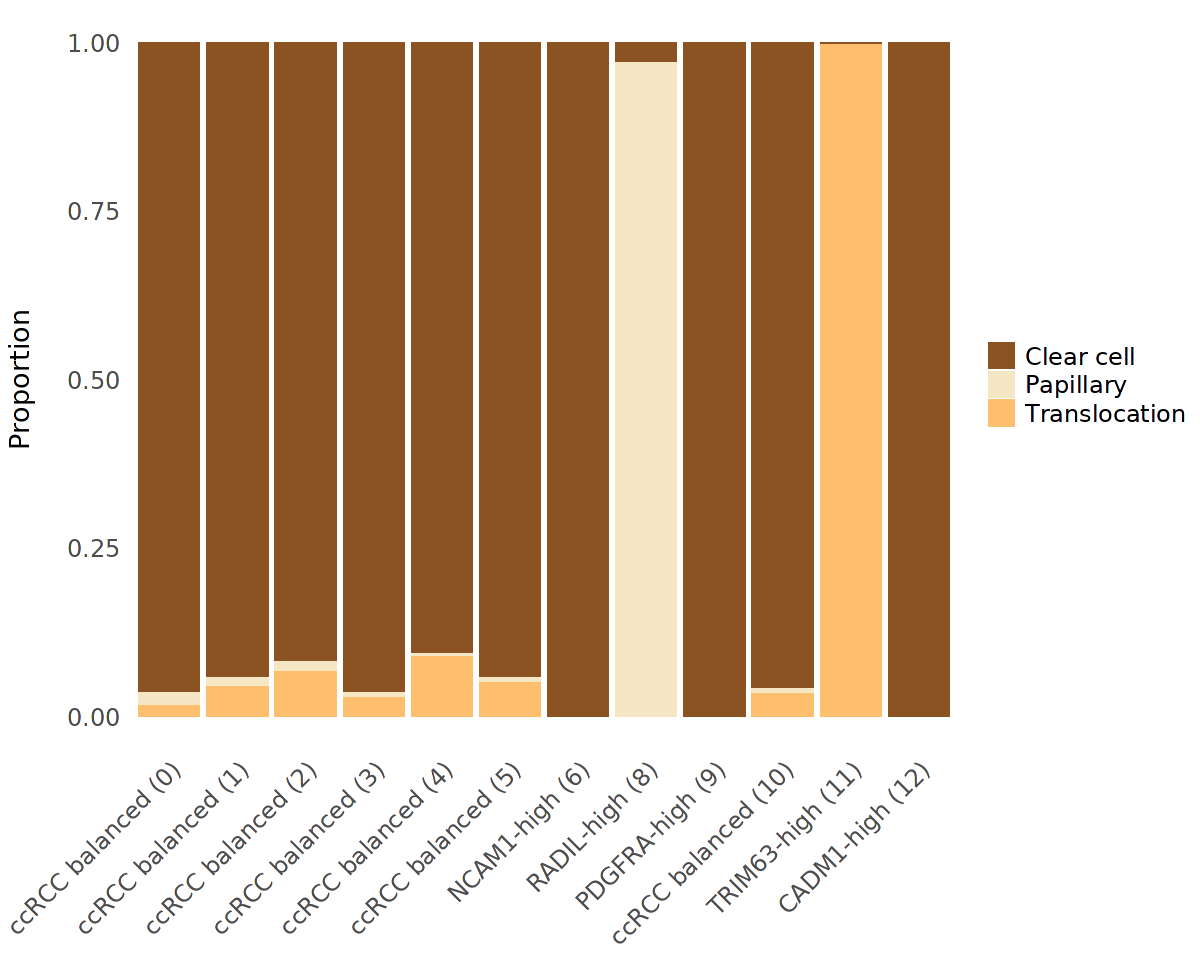

In [12]:
# Calculate proportion of histology per RCC cluster
df_summary <- tumor_filtered@meta.data %>%
  dplyr::count(plot, histology) %>%
  group_by(plot) %>%
  mutate(proportion = n / sum(n)) %>%
  ungroup()

histology_colors = c('#8c5322','#f5e7c3','#fdbf6e')
options(repr.plot.width=10, repr.plot.height=8)
# Create proportional stacked bar plot
ggplot(df_summary, aes(x = plot, y = proportion, fill = histology)) +
    geom_bar(stat = "identity", position = "fill") + 
    labs(y = "Proportion", x = "Cell Type", fill = "Cohort") + 
    theme_classic() + 
    theme(plot.title = element_text(hjust = 0.5, face = 'plain'),
          legend.title = element_blank(),
          legend.text=element_text(size=14),
          axis.title.x=element_blank(),
          axis.title.y = element_text(size = 16, margin = margin(t = 0, r = 20, b = 0, l = 0)),
          axis.ticks=element_blank(), axis.line=element_blank(),
          axis.text.x = element_text(angle = 45, hjust=1, size = 14),
          axis.text.y = element_text(size=14)) +
    scale_fill_manual(values = histology_colors)


# Figure S2B: Proportion of cells in each ccRCC tumor cluster

In [3]:
ccrcc = readRDS('allcells/tumor/seurat_obj/integrated_ccrcc_c0123_plof_anno_Oct2023.rds')

## By sample

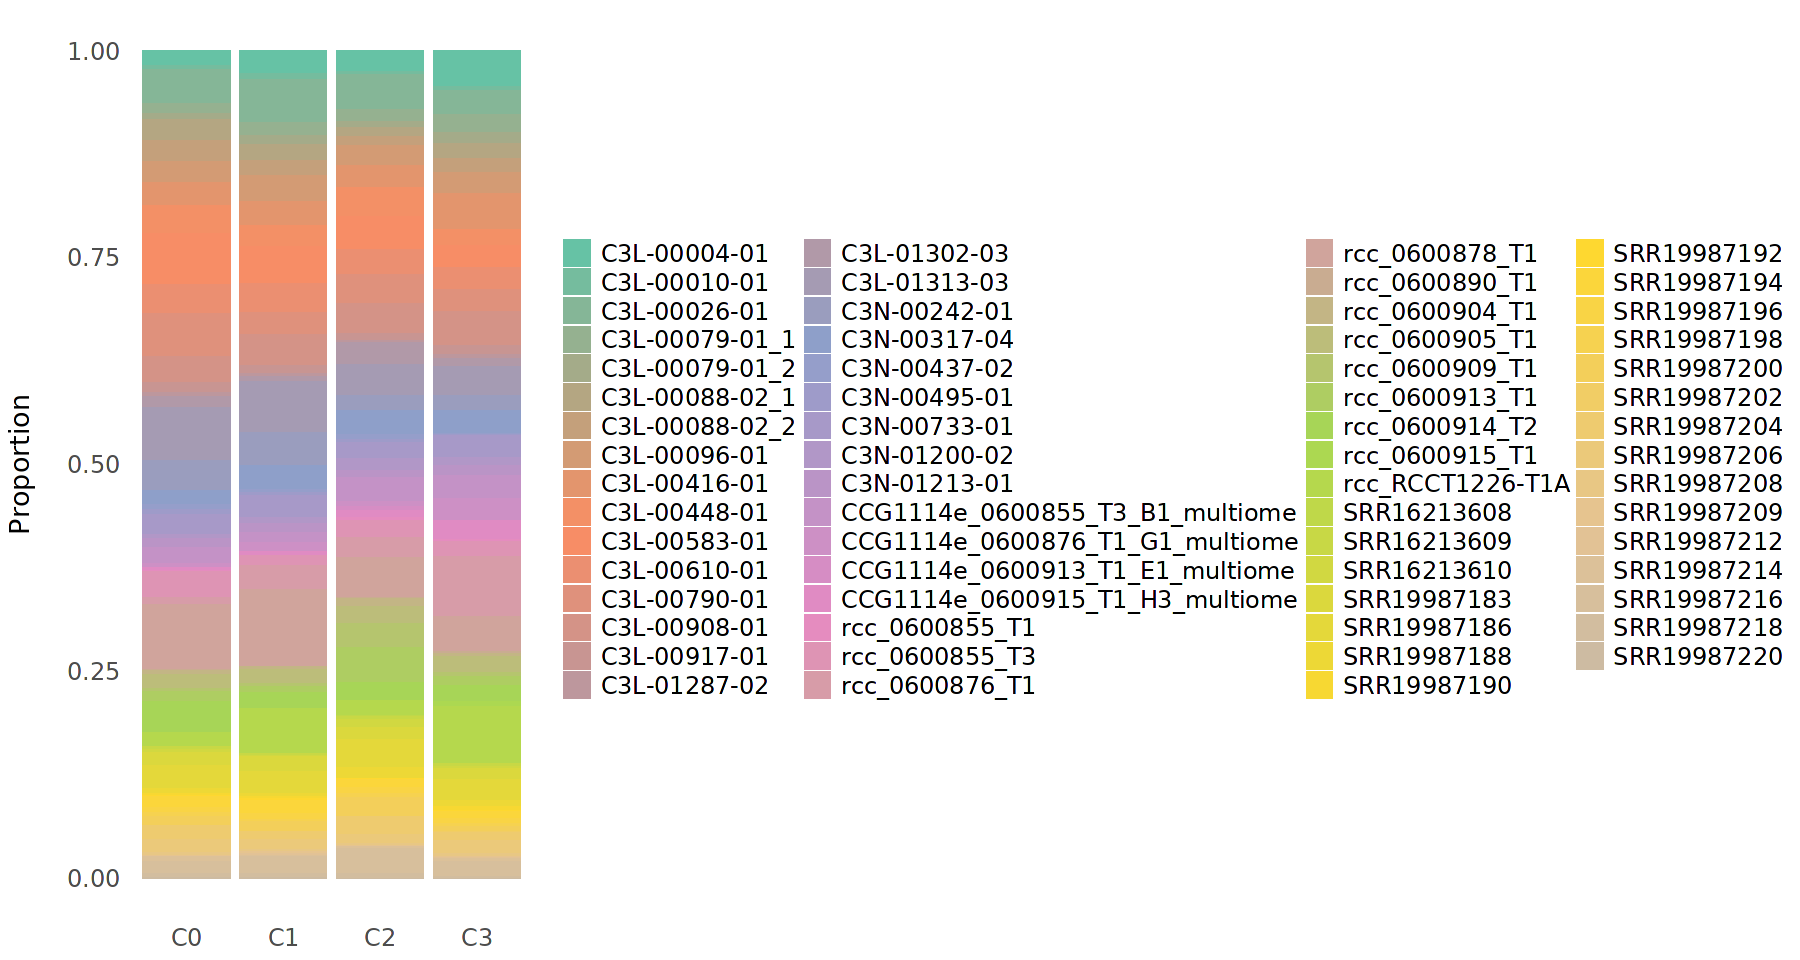

In [7]:
# Calculate proportions of sample ID per ccRCC cluster
ccrcc$plot = paste0('C',ccrcc$seurat_clusters)
df_summary <- ccrcc@meta.data %>%
  dplyr::count(plot, sample) %>%
  group_by(plot) %>%
  mutate(proportion = n / sum(n)) %>%
  ungroup()

options(repr.plot.width=15, repr.plot.height=8)
# Create proportional stacked bar plot
ggplot(df_summary, aes(x = plot, y = proportion, fill = sample)) +
    geom_bar(stat = "identity", position = "fill") + 
    labs(y = "Proportion", x = "Cell Type", fill = "Cohort") + 
    theme_classic() + 
    theme(plot.title = element_text(hjust = 0.5, face = 'plain'),
          legend.title = element_blank(), legend.text=element_text(size=14),
          axis.title.x=element_blank(),
          axis.title.y = element_text(size = 16, margin = margin(t = 0, r = 20, b = 0, l = 0)),
          axis.ticks=element_blank(), axis.line=element_blank(), axis.text.x = element_text(size = 14),
          axis.text.y = element_text(size=14)) + 
    scale_fill_manual(values = sample_cols)

## By originating cohort

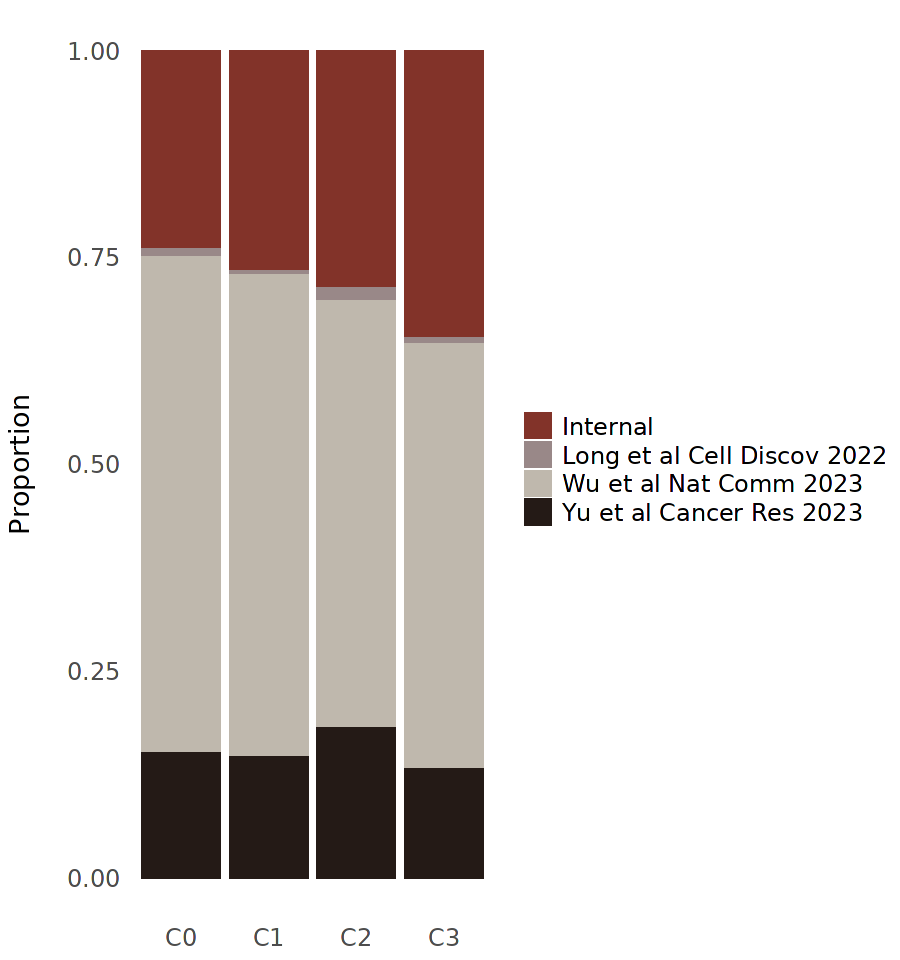

In [8]:
# Calculate proportion of cells per cluster in each cohort
df_summary <- ccrcc@meta.data %>%
  dplyr::count(plot, cohort) %>%
  group_by(plot) %>%
  mutate(proportion = n / sum(n)) %>%
  ungroup()

cohort_colors = c('#823329', '#998888','#BFB8AD', '#241a16')
options(repr.plot.width=7.5, repr.plot.height=8)
# Create proportional stacked bar plot
ggplot(df_summary, aes(x = plot, y = proportion, fill = cohort)) +
    geom_bar(stat = "identity", position = "fill") +
    labs(y = "Proportion", x = "Cell Type", fill = "Cohort") + 
    theme_classic() + 
    theme(plot.title = element_text(hjust = 0.5, face = 'plain'),
          legend.title = element_blank(), legend.text=element_text(size=14),
          axis.title.x=element_blank(),
          axis.title.y = element_text(size = 16, margin = margin(t = 0, r = 20, b = 0, l = 0)),
          axis.ticks=element_blank(), axis.line=element_blank(),
          axis.text.x = element_text(size = 14),
          axis.text.y = element_text(size=14)) +
    scale_fill_manual(values = cohort_colors, labels = c('Internal', 'Long et al Cell Discov 2022','Wu et al Nat Comm 2023', 'Yu et al Cancer Res 2023'))



## By disease stage

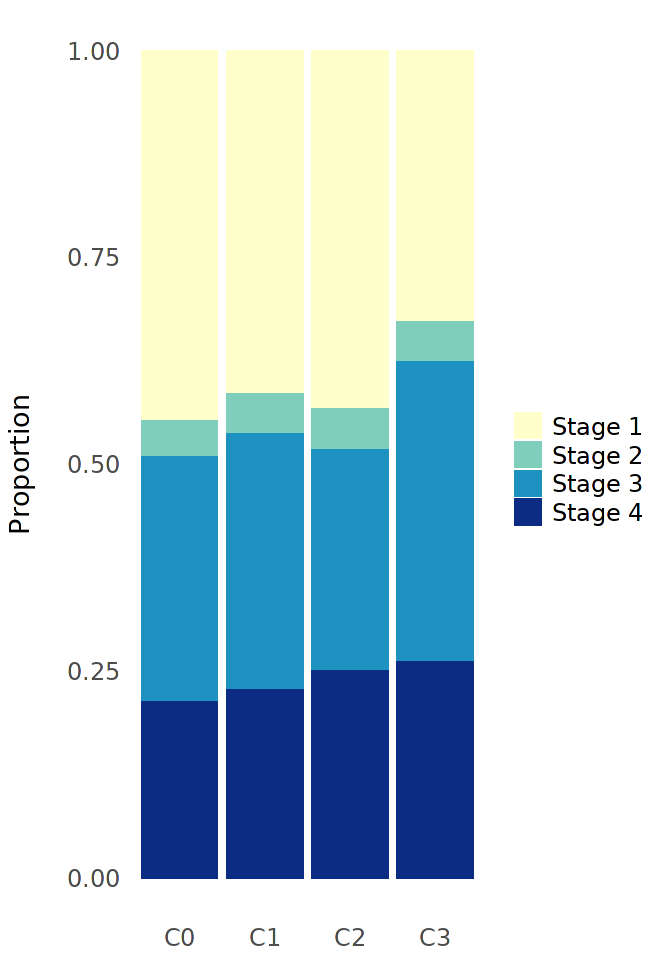

In [10]:
ccrcc$stage = factor(ccrcc$stage)

# Calculate proportions of cell per cluster in each disease stage
df_summary <- ccrcc@meta.data %>%
  dplyr::count(plot, stage) %>%
  group_by(plot) %>%
  mutate(proportion = n / sum(n)) %>%
  ungroup()

stage_colors = c('#ffffcc','#7fcdbb','#1d91c0','#0c2c84')
options(repr.plot.width=5.5, repr.plot.height=8)
# Create proportional stacked bar plot
ggplot(df_summary, aes(x = plot, y = proportion, fill = stage)) +
    geom_bar(stat = "identity", position = "fill") +
    labs(y = "Proportion", x = "Cell Type", fill = "Cohort") + 
    theme_classic() + 
    theme(plot.title = element_text(hjust = 0.5, face = 'plain'),
          legend.title = element_blank(), legend.text=element_text(size=14),
          axis.title.x=element_blank(),
          axis.title.y = element_text(size = 16, margin = margin(t = 0, r = 20, b = 0, l = 0)),
          axis.ticks=element_blank(), axis.line=element_blank(), axis.text.x = element_text(size = 14),
          axis.text.y = element_text(size=14)) +
    scale_fill_manual(values = stage_colors, labels = c('Stage 1', 'Stage 2','Stage 3', 'Stage 4'))


# Table S2

## Sheet A - Differentially accessible genes between each RCC tumor cell cluster

In [11]:
differential_geneactivity_alltum = readRDS('allcells/tumor/findmarkers/level1_annotation_findmarkers_Oct2023.rds')

# Map to IDs used in the figures
newIDs = list(
    "890 EGFR-high" = 'NCAM1-high',
    "909 PDGFRA-high" = 'PDGFRA-high',
    "ccRCC balanced" = 'ccRCC balanced',
    "Papillary RADIL-high" = 'RADIL-high',
    "SRR19987214 CADM1-high" = 'CADM1-high',
    "XpTranslocation TRIM63-high" = 'TRIM63-high')

df = data.frame(cluster = names(newIDs), new_cluster = unlist(unname(newIDs)))
meta_df = dplyr::inner_join(differential_geneactivity_alltum,df , by = 'cluster')
differential_geneactivity_alltum = meta_df
differential_geneactivity_alltum$cluster = differential_geneactivity_alltum$new_cluster
differential_geneactivity_alltum$new_cluster = NULL

# filter to significant and save
write.table(differential_geneactivity_alltum %>% filter(p_val_adj < 0.05), file = '/home/jupyter/scATAC_analysis/edit/snatac-rcc-manuscript-data/s2a_RCCtumorcells_diffgenes.txt', sep = '\t', quote = F, col.names = T, row.names = F)

## Sheet B - Differentially accessible peaks between each ccRCC tumor cell cluster

In [12]:
da_peaks = read.table('allcells/tumor/findmarkers/ccrcc_balanced_peaks_nov2023.txt', row.names = NULL)
# Filter to significant
sigpeaks = da_peaks %>% 
    filter(p_val_adj < 0.05) %>% 
    rename(peak = gene)
sigpeaks$row.names = NULL
# Set names as used in figures
sigpeaks$cluster = paste0('C',sigpeaks$cluster)

write.table(sigpeaks, '/home/jupyter/scATAC_analysis/edit/snatac-rcc-manuscript-data/s2b_ccrcc_states_diffpeaks.txt', quote = F, row.names = F, col.names = T, sep = '\t')

## Sheet C - GREAT pathway enrichment results for ccRCC epigenetic program peak sets

In [13]:
header = read.table('allcells/tumor/great/greatExportAll_forheader.tsv', fill = TRUE, sep = "\t", quote = "", row.names = NULL)
header = unlist(unname(t(header[1,])[,1]))
keep = c('GO Biological Process','Disease Ontology', 'MSigDB Pathway')
results = list()

Cluster 1

In [14]:
great_results = read.table('allcells/tumor/great/greatExportAll_c1.tsv',  sep = "\t", quote = "", row.names = NULL, fill = TRUE)
colnames(great_results) = header
great_results = great_results[,-c(23,24)]
great_results$cluster = 'C1'
# GREAT default term filtering
great_results = great_results %>%
filter((Ontology %in% keep) &
       (RegionFoldEnrich > 2) &
        (TotalGenes > 1) &
        (BinomFdrQ < 0.05) &
        (HyperFdrQ < 0.05)) 
dim(great_results)
results[['C1']] = great_results

[1]  7 23

Cluster 2

In [15]:
great_results = read.table('allcells/tumor/great/greatExportAll_c2.tsv',  sep = "\t", quote = "", row.names = NULL, fill = TRUE)
colnames(great_results) = header
great_results = great_results[,-c(23,24)]
great_results$cluster = 'C2'
# GREAT default term filtering
great_results = great_results %>%
filter((Ontology %in% keep) &
       (RegionFoldEnrich > 2) &
        (TotalGenes > 1) &
        (BinomFdrQ < 0.05) &
        (HyperFdrQ < 0.05)) 
dim(great_results)
results[['C2']] = great_results

[1] 160  23

Cluster 3

In [16]:
great_results = read.table('allcells/tumor/great/greatExportAll_c3.tsv',  sep = "\t", quote = "", row.names = NULL, fill = TRUE)
colnames(great_results) = header
great_results = great_results[,-c(23,24)]
great_results$cluster = 'C3'
# GREAT default term filtering
great_results = great_results %>%
filter((Ontology %in% keep) &
       (RegionFoldEnrich > 2) &
        (TotalGenes > 1) &
        (BinomFdrQ < 0.05) &
        (HyperFdrQ < 0.05)) 
dim(great_results)
results[['C3']] = great_results

[1] 52 23

In [17]:
write.table(dplyr::bind_rows(results), '/home/jupyter/scATAC_analysis/edit/snatac-rcc-manuscript-data/s2c_ccrcc_states_GREAT_output.txt', sep = '\t', quote = F, row.names = F, col.names = T)

## Sheet D - Transcription factor binding site motif enrichment results for ccRCC epigenetic program peak sets

In [19]:
ccrcc = readRDS('allcells/tumor/seurat_obj/integrated_ccrcc_c0123_plof_anno_Oct2023.rds')
sigpeaks = read.table('/home/jupyter/scATAC_analysis/edit/snatac-rcc-manuscript-data/s2b_ccrcc_states_diffpeaks.txt',sep = '\t', header = T)

In [20]:
# get enriched motif per peak set, c0 had no significant peaks
DefaultAssay(ccrcc) = 'ATAC'
results = list()
clusters = c('C1','C2','C3')
for (cluster in clusters) {
    cluster_peaks = sigpeaks %>% filter(cluster == !!cluster)
    
    # Define a set of background peaks
    ## Find peaks that are open in a significant portion of cells
    percent_to_num_cells = ceiling(nrow(ccrcc@meta.data) * 0.1)
    open_peaks <- AccessiblePeaks(ccrcc, min.cells = percent_to_num_cells)

    ## Match the overall GC content in the peak set
    meta.feature <- GetAssayData(ccrcc, assay = "ATAC", slot = "meta.features")
    peaks_matched <- MatchRegionStats(
    meta.feature = meta.feature[open_peaks, ],
    query.feature = meta.feature[cluster_peaks$peak, ]
    )
    # Hypergeometric test for enrichment
    enriched.motifs <- FindMotifs(
    object = ccrcc,
    features = cluster_peaks$peak,
        background = peaks_matched
    )
    
    enriched.motifs$cluster = cluster
    results[[cluster]] = enriched.motifs
}

enriched.motifs.all = dplyr::bind_rows(results)

Matching GC.percent distribution

Testing motif enrichment in 277 regions

Matching GC.percent distribution

Testing motif enrichment in 328 regions

Matching GC.percent distribution

Testing motif enrichment in 422 regions



In [21]:
write.table(enriched.motifs.all %>% filter(p.adjust < 0.05),
           file = '/home/jupyter/scATAC_analysis/edit/snatac-rcc-manuscript-data/s2d_ccrcc_states_tfmotifs.txt', sep = '\t', quote = F, row.names = F, col.names = T)

## Writing out tables to Excel workbook
Switch to python kernel. 

In [1]:
import pandas as pd

In [2]:
rcc_dags = pd.read_csv('snatac-rcc-manuscript-data/s2a_RCCtumorcells_diffgenes.txt', sep = '\t')
rcc_dags.head()

ccrcc_daps = pd.read_csv('snatac-rcc-manuscript-data/s2b_ccrcc_states_diffpeaks.txt', sep = '\t')
ccrcc_daps.head()

ccrcc_pathways = pd.read_csv('snatac-rcc-manuscript-data/s2c_ccrcc_states_GREAT_output.txt', sep ='\t')
ccrcc_pathways.head()

ccrcc_tf_motifs = pd.read_csv('snatac-rcc-manuscript-data/s2d_ccrcc_states_tfmotifs.txt', sep = '\t')
ccrcc_tf_motifs.head()

,motif,observed,background,percent.observed,percent.background,fold.enrichment,pvalue,motif.name,p.adjust,cluster
0,MA1494.1,117,1970,42.238267,19.70,2.144074,2.785238e-18,HNF4A(var.2),2.077788e-15,C1
1,MA0114.4,129,2412,46.570397,24.12,1.930779,1.227618e-16,HNF4A,4.579014e-14,C1
2,MA0484.2,128,2422,46.209386,24.22,1.907902,4.945594e-16,HNF4G,1.229804e-13,C1
3,MA0512.2,105,2274,37.906137,22.74,1.666937,5.846388e-09,Rxra,1.090351e-06,C1
4,MA1537.1,111,2503,40.072202,25.03,1.600967,1.699463e-08,NR2F1(var.2),2.535599e-06,C1


In [3]:
with pd.ExcelWriter('snatac-rcc-manuscript-data/table_S2.xlsx') as writer:  
    rcc_dags.to_excel(writer, sheet_name='A', index = False)
    ccrcc_daps.to_excel(writer, sheet_name='B', index = False)
    ccrcc_pathways.to_excel(writer, sheet_name='C', index = False)
    ccrcc_tf_motifs.to_excel(writer, sheet_name='D', index = False)

Add README with titles in excel app. 